### Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras import regularizers
from keras.datasets import cifar10
from keras.layers import Concatenate
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation

### Set Hyperparameters

In [2]:
batch_size   = 64
num_classes  = 10
epochs       = 250
l            = 30
num_filter   = 30
compression  = 0.5
dropout_rate = 0.2
weight_decay = 1e-4

In [3]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

### Load CIFAR10 Data

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channels = X_train.shape[1],X_train.shape[2],X_train.shape[3]

170508288/170498071 [==============================] - 2s 0us/step


In [5]:
# Convert integers to float
X_train=X_train.astype("float32")  
X_test=X_test.astype("float32")

In [6]:
# Normalise and center the mean
mean=np.mean(X_train)
std=np.std(X_train)

X_train=(X_train-mean)/std
X_test=(X_test-mean)/std

In [7]:
# Convert labels to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

### Data Augmentation
Source: https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb

https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/

In [8]:
datagen = ImageDataGenerator(rotation_range=15,
                            horizontal_flip=True,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.3)
datagen.fit(X_train)

X_train = X_train.reshape(X_train.shape[0], img_height, img_width, channels)
X_test = X_test.reshape(X_test.shape[0], img_height, img_width, channels)
input_shape = (img_height, img_width, 1)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'Train samples')
print(X_test.shape[0], 'Test samples')


X_train shape: (50000, 32, 32, 3)
50000 Train samples
10000 Test samples


In [9]:
print('Train Set Dimension: ', X_train.shape)
print('Test Set Dimension: ', X_test.shape)

Train Set Dimension:  (50000, 32, 32, 3)
Test Set Dimension:  (10000, 32, 32, 3)


### Define Building Blocks of DenseNet

In [10]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = SeparableConv2D(int(num_filter*compression), (3,3), use_bias=False,kernel_regularizer=regularizers.l2(weight_decay),padding='same')(relu)
#         if dropout_rate>0:
#             Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

# Transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = SeparableConv2D(int(num_filter*compression), (1,1), use_bias=False, kernel_regularizer=regularizers.l2(weight_decay), padding='same')(relu)
#     if dropout_rate>0:
#          Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

# Output layer
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    return output

In [11]:
input = Input(shape=(img_height, img_width, channels,))
# First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)
First_Conv2D = SeparableConv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

2022-02-18 14:22:05.759084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 14:22:05.859044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 14:22:05.859769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 14:22:05.860868: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 32, 32, 30)   117         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 30)   120         separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 30)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
# Inspect Number of Layers
print(len(model.layers))

499


### Define Loss Function and Optimizer

In [14]:
opt_rms = RMSprop(learning_rate=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt_rms,metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

### Train the DenseNet

In [15]:
# Train with image augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch = len(X_train) / 128, epochs=epochs, validation_data=(X_test, y_test),callbacks=[LearningRateScheduler(lr_schedule)])

2022-02-18 14:22:11.433768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250


2022-02-18 14:22:38.099568: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


390/390 [==============================] - 176s 365ms/step - loss: 1.9017 - accuracy: 0.3288 - val_loss: 2.1443 - val_accuracy: 0.1748
Epoch 2/250
390/390 [==============================] - 139s 356ms/step - loss: 1.5137 - accuracy: 0.4567 - val_loss: 1.5747 - val_accuracy: 0.4602
Epoch 3/250
390/390 [==============================] - 149s 380ms/step - loss: 1.3253 - accuracy: 0.5213 - val_loss: 1.3212 - val_accuracy: 0.5374
Epoch 4/250
390/390 [==============================] - 139s 356ms/step - loss: 1.2083 - accuracy: 0.5691 - val_loss: 2.1095 - val_accuracy: 0.4320
Epoch 5/250
390/390 [==============================] - 139s 355ms/step - loss: 1.1143 - accuracy: 0.6026 - val_loss: 1.7400 - val_accuracy: 0.4894
Epoch 6/250
390/390 [==============================] - 139s 356ms/step - loss: 1.0301 - accuracy: 0.6305 - val_loss: 1.0788 - val_accuracy: 0.6438
Epoch 7/250
390/390 [==============================] - 149s 382ms/step - loss: 0.9872 - accuracy: 0.6498 - val_loss: 0.9867 - val_

### Plot Accuracy Curves

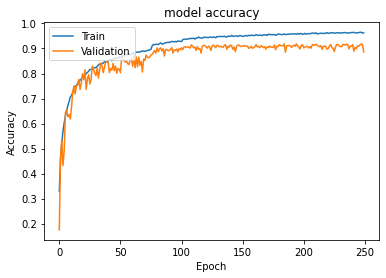

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test the model

In [17]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 12s 40ms/step - loss: 3.9366 - accuracy: 0.8863
Test loss: 3.93658447265625
Test accuracy: 0.8863000273704529


### Save the trained weights in to .h5 format

In [18]:
model.save_weights("DNST_model_TestAcc_{}.h5".format(np.round(score[1],2)))
print("Saved model to disk")

Saved model to disk
